# Task

Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

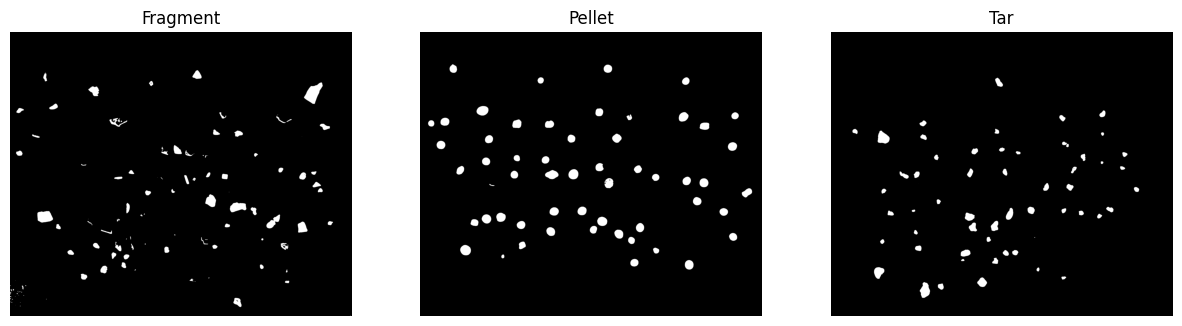

In [2]:
# Load the three images: fragments, pellets, and tar
frag = cv2.imread('./Images/Waste/fragment-03-olympus-10-01-2020.JPG')
pellet = cv2.imread('./Images/Waste/pellet-03-olympus-10-01-2020.JPG')
tar = cv2.imread('./Images/Waste/tar-03-olympus-10-01-2020.JPG')

# Crop the images to remove shadows that appear in the borders
left_limit, right_limit = 750, 4000
upper_limit, lower_limit = 0, 2700

frag_r = frag[upper_limit:lower_limit, left_limit:right_limit]
pellet_r = pellet[upper_limit:lower_limit, left_limit:right_limit]
tar_r = tar[upper_limit:lower_limit, left_limit:right_limit]

# Convert the cropped images to grayscale
frag_gris = cv2.cvtColor(frag_r, cv2.COLOR_BGR2GRAY)
pellet_gris = cv2.cvtColor(pellet_r, cv2.COLOR_BGR2GRAY)
tar_gris = cv2.cvtColor(tar_r, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale images (filtering)
frag_filtrado = cv2.GaussianBlur(frag_gris, (15, 15), 0)
pellet_filtrado = cv2.GaussianBlur(pellet_gris, (15, 15), 0)

# Apply binary thresholding to fragments and pellets with a fixed threshold
_, frag_umbral = cv2.threshold(frag_filtrado, 115, 255, cv2.THRESH_BINARY_INV)
_, pel_umbral = cv2.threshold(pellet_filtrado, 100, 255, cv2.THRESH_BINARY_INV)

# Apply Otsu's thresholding method (best suited for the tar image)
_, tar_umbral = cv2.threshold(tar_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Display the thresholded images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.title('Fragment')
plt.axis("off")
plt.imshow(frag_umbral, cmap='gray') 

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pel_umbral, cmap='gray') 

plt.subplot(133)
plt.title('Tar')
plt.axis("off")
plt.imshow(tar_umbral, cmap='gray') 

plt.show()

In [3]:
# Classification of fragments, pellets, and tar

def clasificarElementos(imagen, color):
    # Find contours in the binary image
    contornos, _ = cv2.findContours(imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize counters for fragments, pellets, and tar
    fragments, pellets, tar = 0, 0, 0
    result = []
    
    # Loop through each contour detected in the image
    for contorno in contornos:
        # Calculate area and perimeter of the contour
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        
        # Get the bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(contorno)
        
        # Calculate the minimum enclosing circle around the contour
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)
        
        # Calculate compactness: a measure of shape (perimeter^2 / area)
        compacidad = (perimetro ** 2) / area if area > 0 else 0

        # Initialize ellipse-related variables for contours that can be approximated as ellipses
        eje_mayor, eje_menor, relacion_ejes_elipse, excentricidad = 0, 0, 0, 0
        
        # If the contour has more than 5 points, fit an ellipse to it
        if contorno.shape[0] > 5:
            elipse = cv2.fitEllipse(contorno)
            eje_mayor = elipse[1][1]
            eje_menor = elipse[1][0]
            relacion_ejes_elipse = eje_menor / eje_mayor  # Aspect ratio of the ellipse's axes

        # Calculate aspect ratio (width / height) and area-to-bounding-rectangle ratio
        relacion_aspecto = w / h
        relacion_area_contenedor = area / (w * h)

        # Approximate the contour using a polygon
        epsilon = 0.02 * cv2.arcLength(contorno, True)
        lados_aproximados = cv2.approxPolyDP(contorno, epsilon, True)

        # Calculate the average intensity inside the contour
        mask = np.zeros(color.shape, dtype=np.uint8)                            # Create an empty mask
        cv2.drawContours(mask, [contorno], -1, (255), thickness=cv2.FILLED)     # Draw the contour on the mask
        mean_color = cv2.mean(color, mask=mask)                                 # Get the mean intensity value
        mean_value = mean_color[0]

        # Classification rules for pellets
        if 13 < compacidad < 15 and np.isclose(relacion_aspecto, 1.0, rtol=1):
            pellets += 1
            result.append(1)  # Label as pellet
        
        # Classification rules for tar
        elif mean_value < 55 and compacidad > 15 and 0.55 < relacion_area_contenedor < 0.75:
            tar += 1
            result.append(2)  # Label as tar
        
        # Classification rules for fragments
        elif relacion_area_contenedor < 0.65 and len(lados_aproximados) < 9 and relacion_ejes_elipse < 0.78:
            fragments += 1
            result.append(0)  # Label as fragment
        
        # Skip if none of the classification rules are met
        else:
            continue
    
    # Print the classification results
    print(f'Fragments: {fragments}, Pellets: {pellets}, Tar: {tar}, Total: {fragments + pellets + tar}')

    # Return the count of each type and the result list (classification for each contour)
    return [fragments, pellets, tar], result

________________________
Elements Detected
________________________

Fragments: 73, Pellets: 9, Tar: 0, Total: 82
Fragments: 2, Pellets: 46, Tar: 0, Total: 48
Fragments: 4, Pellets: 3, Tar: 48, Total: 55
________________________
Partial Scores
________________________

-- Fragment Results --
Precision (TP/(TP+FP)) = 0.9240506329113924
Recall (TP/(TP+FN)) = 0.8902439024390244
F1 Score (2*(precision*recall)/(precision+recall)) = 0.9068322981366461

-- Pellets Results --
Precision (TP/(TP+FP)) = 0.7931034482758621
Recall (TP/(TP+FN)) = 0.9583333333333334
F1 Score (2*(precision*recall)/(precision+recall)) = 0.8679245283018867

-- Tar Results --
Precision (TP/(TP+FP)) = 1.0
Recall (TP/(TP+FN)) = 0.8727272727272727
F1 Score (2*(precision*recall)/(precision+recall)) = 0.9320388349514563

________________________
Total Scores
________________________

Accuracy (TP/(n))= 0.601010101010101
Precision (TP/(TP+FP)) = 0.9057180270624182
Recall (TP/(TP+FN)) = 0.9071015028332101
F1 Score (2*(precision

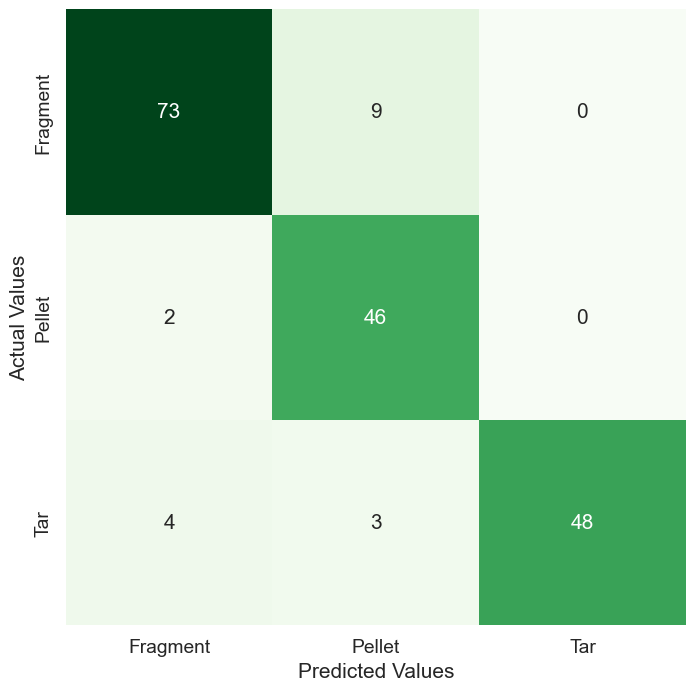

In [6]:
# Print a header for elements detected
print("________________________\nElements Detected\n________________________\n")

# Call the classification function for fragments, pellets, and tar
total_frag, count_frag = clasificarElementos(frag_umbral, frag_gris)
total_pellet, count_pellet = clasificarElementos(pel_umbral, pellet_gris)
total_tar, count_tar = clasificarElementos(tar_umbral, tar_gris)

# Initialize a list to store actual fragment labels
real_frag = []
real_frag = [0 for i in range(88)]  # Assuming there are 88 real fragments

# Calculate the total true positives across all categories
tp = (total_frag[0] + total_pellet[1] + total_frag[2])

# Calculate the total number of elements (n)
n = (max(len(count_frag), 88) + max(len(count_pellet), 55) + max(len(count_tar), 54))

# Calculate accuracy: True positives (TP) divided by the total number of elements (n)
accuracy = tp / n

# Store the classification results in a list
results = [total_frag, total_pellet, total_tar]
final_score = []

# Print a header for partial scores
print("________________________\nPartial Scores\n________________________\n")

# Loop through the results to calculate precision, recall, and F1-score for each category
for i in range(0, len(results)):
    # Calculate precision: TP / (TP + FP)
    precision = results[i][i] / (results[0][i] + results[1][i] + results[2][i])
    
    # Calculate recall: TP / (TP + FN)
    recall = results[i][i] / (results[i][0] + results[i][1] + results[i][2])
    
    # Calculate F1 score: harmonic mean of precision and recall
    f1score = 2 * ((precision * recall) / (precision + recall))
    
    # Print the results for each category
    if i == 0:
        print("-- Fragment Results --")
    elif i == 1:
        print("-- Pellets Results --")
    else:
        print("-- Tar Results --")

    print(f"Precision (TP/(TP+FP)) = {precision}")
    print(f"Recall (TP/(TP+FN)) = {recall}")
    print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")
    
    # Append the scores to the final_score list
    final_score.append([precision, recall, f1score])
    print()

# Print a header for total scores
print("________________________\nTotal Scores\n________________________\n")

# Print the overall accuracy
print(f"Accuracy (TP/(n))= {accuracy}")

# Calculate and print the overall precision, recall, and F1-score by averaging across categories
print(f"Precision (TP/(TP+FP)) = {(final_score[0][0] + final_score[1][0] + final_score[2][0]) / 3}")
print(f"Recall (TP/(TP+FN)) = {(final_score[0][1] + final_score[1][1] + final_score[2][1]) / 3}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {(final_score[0][2] + final_score[1][2] + final_score[2][2]) / 3}")

# Create a confusion matrix using the results for fragments, pellets, and tar
matriz_confusion = np.array([total_frag, total_pellet, total_tar])

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)

# Use seaborn to create a heatmap of the confusion matrix
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Greens', 
            xticklabels=['Fragment', 'Pellet', 'Tar'], 
            yticklabels=['Fragment', 'Pellet', 'Tar'])

# Add labels to the plot
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# Display the plot
plt.show()